In [50]:
import pandas as pd
import numpy as np
import torch
import importlib
from utils.utils_dataset import prepare_k_fold_non_iid_dataset, plot_dataset_split, display_dataset_split
from sklearn import datasets
from sklearn.model_selection import KFold
from utils.utils_train import train_supervised, train_unsupervised, calculate_metrics_statistics, format_metrics, calculate_cluster_stats
from utils.utils_plots import plot_first_feature, plot_first_feature_horizontal, save_figure
from utils.utils_train import test_model   

In [51]:
from model.eGauss_plus import eGAUSSp

# Model parameters
local_model_params = {
    "feature_dim": 4,
    "num_classes": 3,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 1.0,
    "S_0": 1e-8,
    "c_max": 4,
    "device": torch.device("cpu")
}
federated_model_params = {
    "feature_dim": 4,
    "num_classes": 3,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 2,
    "S_0": 1e-8,
    "c_max": 2,
    "device": torch.device("cpu")
}


*** Start of fold 0. ***

Training model for client 1
Evolving has been enabled.
Processed 22 points.Number of clusters: 17

Testing model for client 1
Evolving has been disabled.
Test Metrics: {'accuracy': 0.7, 'precision': 0.8588235294117648, 'recall': 0.7, 'f1_score': 0.6349523809523809}
Number of clusters with multiple samples for Client 1 = 5

Training model for client 2
Evolving has been enabled.
Processed 28 points.Number of clusters: 4

Testing model for client 2
Evolving has been disabled.
Test Metrics: {'accuracy': 0.7333333333333333, 'precision': 0.826086956521739, 'recall': 0.7333333333333333, 'f1_score': 0.6280701754385966}
Number of clusters with multiple samples for Client 2 = 2

Training model for client 3
Evolving has been enabled.
Processed 40 points.Number of clusters: 10

Testing model for client 3
Evolving has been disabled.
Test Metrics: {'accuracy': 0.7333333333333333, 'precision': 0.8111111111111111, 'recall': 0.7333333333333333, 'f1_score': 0.7363636363636364}

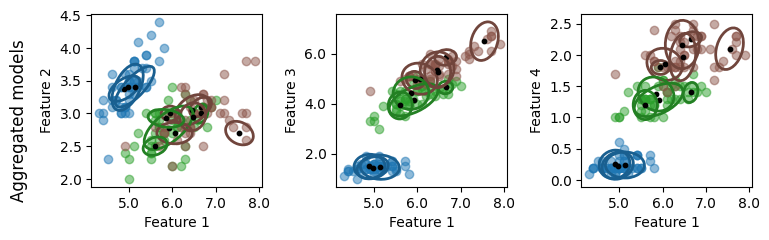

Figure saved as Images/iris_federated_pre_merge.svg in svg format.
Figure saved as Images/iris_federated_pre_merge.pdf in pdf format.
Number of clusters after transfer = 13

Testing federated model
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9666666666666667, 'precision': 0.9694444444444444, 'recall': 0.9666666666666667, 'f1_score': 0.9665976535541752}


In [52]:
# Load the Iris dataset
iris = datasets.load_iris()

X = iris.data
y = iris.target

num_clients = 4
num_splits = 5

kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)  

# Initialize arrays to track samples per class for each client in each fold
samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

# Main loop for k-fold cross-validation
all_client_metrics = [[] for _ in range(num_clients)]
all_client_clusters = [[] for _ in range(num_clients)]

all_federated_metrics = []
all_federated_clusters = []

for i_fold, (train_index, test_index) in enumerate(kf.split(iris.data)):
    print(f"\n*** Start of fold {i_fold}. ***")
    
    #Split the data
    train_data, test_data, all_data = prepare_k_fold_non_iid_dataset(X, y, train_index, test_index, num_clients)
    
    #Create the models
    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
    federated_model = eGAUSSp(**federated_model_params)
    #federated_model.toggle_debugging(True)
    
    #Train the models
    for client_idx, client_model in enumerate(local_models):
        
        # Count the number of samples per class for this client in this fold
        for class_idx in range(client_model.num_classes):
            class_samples = torch.sum(train_data[client_idx][1] == class_idx)
            samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

        #Supervised clustering
        print(f"\nTraining model for client {client_idx + 1}")
        train_supervised(client_model, train_data[client_idx]) 

        #Test the local models
        print(f"\nTesting model for client {client_idx + 1}")
        metrics = test_model(client_model, test_data)
        print(f"Test Metrics: {metrics}")
        all_client_metrics[client_idx].append(metrics)

        #Save the number of clusters
        num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1).item()
        print(f"Number of clusters with multiple samples for Client {client_idx + 1} = {num_client_clusters}")
        all_client_clusters[client_idx].append(num_client_clusters)

    #Aggregate local models
    for client_model in local_models:
        federated_model.federal_agent.merge_model_privately(client_model, 1)
        
    #Plot the Aggregated model
    if i_fold == (num_splits-1):
        fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=0, title="Aggregated models")   
        save_figure(fig, "Images/iris_federated_pre_merge.svg","svg")
        save_figure(fig, "Images/iris_federated_pre_merge.pdf","pdf")


    #Merge the federated model clusters
    print(f"Number of clusters after transfer = {federated_model.c}")
    federated_model.federal_agent.federated_merging()
    num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()

    #Test the federated model
    print(f"\nTesting federated model")
    federated_metrics = test_model(federated_model, test_data)
    print(f"Test Metrics: {federated_metrics}")
    all_federated_metrics.append(federated_metrics)
    all_federated_clusters.append(num_federated_clusters)


In [53]:
# Calculate the average samples per class for each client
average_samples_per_class_per_client = np.mean(samples_per_class_per_client, axis=2)
print("Average samples per class for each client:")
print(average_samples_per_class_per_client)

# At the end of all folds, calculate and format mean and standard deviation
# Compute and print metrics for each client
for client_idx, client_metrics in enumerate(all_client_metrics):
    formatted_metrics = calculate_metrics_statistics(client_metrics)
    
    print(f"\nMetrics for Client {client_idx + 1} (mean ± std):")
    for metric, value in formatted_metrics.items():
        print(f"{metric}: {value}")

#Calculate evaluation metrics for the federated model
avg_std_federated_metrics = calculate_metrics_statistics(all_federated_metrics)

print("\nFederated Model - Metrics (mean ± std):")
for metric, value in avg_std_federated_metrics.items():
    print(f"{metric}: {value}")

# Compute and print cluster stats for each client and federated model
for client_idx, client_clusters in enumerate(all_client_clusters):
    avg_clusters, std_clusters = calculate_cluster_stats(client_clusters)
    print(f"\nClient {client_idx + 1} - Average Number of Clusters (mean ± std): {avg_clusters:.2f} ± {std_clusters:.2f}")

# Compute and print cluster stats for the federated model
avg_fed_clusters, std_fed_clusters = calculate_cluster_stats(all_federated_clusters)
print(f"\nFederated Model - Average Number of Clusters (mean ± std): {avg_fed_clusters:.2f} ± {std_fed_clusters:.2f}")


Average samples per class for each client:
[[ 0.  10.8 10.8]
 [18.4  0.  11.4]
 [10.6 19.6  8.4]
 [11.   9.6  9.4]]

Metrics for Client 1 (mean ± std):
accuracy: 0.61 ± 0.13
precision: 0.78 ± 0.06
recall: 0.61 ± 0.13
f1_score: 0.50 ± 0.15

Metrics for Client 2 (mean ± std):
accuracy: 0.67 ± 0.04
precision: 0.84 ± 0.03
recall: 0.67 ± 0.04
f1_score: 0.56 ± 0.04

Metrics for Client 3 (mean ± std):
accuracy: 0.90 ± 0.10
precision: 0.92 ± 0.07
recall: 0.90 ± 0.10
f1_score: 0.90 ± 0.10

Metrics for Client 4 (mean ± std):
accuracy: 0.89 ± 0.04
precision: 0.90 ± 0.04
recall: 0.89 ± 0.04
f1_score: 0.89 ± 0.04

Federated Model - Metrics (mean ± std):
accuracy: 0.97 ± 0.03
precision: 0.98 ± 0.02
recall: 0.97 ± 0.03
f1_score: 0.97 ± 0.03

Client 1 - Average Number of Clusters (mean ± std): 4.20 ± 1.30

Client 2 - Average Number of Clusters (mean ± std): 2.40 ± 0.55

Client 3 - Average Number of Clusters (mean ± std): 3.80 ± 0.84

Client 4 - Average Number of Clusters (mean ± std): 3.80 ± 0.84

Fed

In [73]:
# Assuming the data and functions are defined as before

# Start the LaTeX table code

# Start the LaTeX table code
latex_table = r"""\begin{table}[ht]
\centering
\setlength{\tabcolsep}{4pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
"""

# Add the average samples per class for each client
samples_row = ""
for samples in average_samples_per_class_per_client:
    samples_row += " & " + "/".join([f"{x:.1f}" if x != 0 else "0" for x in samples])
latex_table += samples_row + " & \\\\" + "\n"

latex_table += r"\midrule" + "\n"
# Add rows for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['accuracy', 'precision', 'recall', 'f1 score']
for i, metric in enumerate(metrics):
    row = metric_names[i].capitalize() + r' $\uparrow$'
    for client_metrics in all_client_metrics:
        formatted_metric = calculate_metrics_statistics(client_metrics)[metric]
        row += f' & {formatted_metric}'
    fed_formatted_metric = calculate_metrics_statistics(all_federated_metrics)[metric]
    row += f' & \bf{{{fed_formatted_metric}}}'
    latex_table += row + r' \\' + '\n'

# Add row for clusters
cluster_row = r'\#Clusters $\downarrow$'
for client_clusters in all_client_clusters:
    avg_clusters, std_clusters = calculate_cluster_stats(client_clusters)
    cluster_row += f' & {avg_clusters:.2f} ± {std_clusters:.2f}'
avg_fed_clusters, std_fed_clusters = calculate_cluster_stats(all_federated_clusters)
cluster_row += r' & \bf'+f'{{{avg_fed_clusters:.2f} ± {std_fed_clusters:.2f}}}'
latex_table += cluster_row + r' \\' + '\n'

# End the LaTeX table code
latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

# Print the complete LaTeX table
print(latex_table)


\begin{table}[ht]
\centering
\setlength{\tabcolsep}{4pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
 & 0/10.8/10.8 & 18.4/0/11.4 & 10.6/19.6/8.4 & 11.0/9.6/9.4 & \\
\midrule
Accuracy $\uparrow$ & 0.61 ± 0.13 & 0.67 ± 0.04 & 0.90 ± 0.10 & 0.89 ± 0.04 &f{0.97 ± 0.03} \\
Precision $\uparrow$ & 0.78 ± 0.06 & 0.84 ± 0.03 & 0.92 ± 0.07 & 0.90 ± 0.04 &f{0.98 ± 0.02} \\
Recall $\uparrow$ & 0.61 ± 0.13 & 0.67 ± 0.04 & 0.90 ± 0.10 & 0.89 ± 0.04 &f{0.97 ± 0.03} \\
F1 score $\uparrow$ & 0.50 ± 0.15 & 0.56 ± 0.04 & 0.90 ± 0.10 & 0.89 ± 0.04 &f{0.97 ± 0.03} \\
\#Clusters $\downarrow$ & 4.20 ± 1.30 & 2.40 ± 0.55 & 3.80 ± 0.84 & 3.80 ± 0.84 & +\bf{3.60 ± 0.89} \\
\bottomrule
\end{tabular}
\end{table}



Client 1: {1: 7, 2: 12}
Client 2: {0: 20, 2: 11}
Client 3: {0: 11, 1: 23, 2: 6}
Client 4: {0: 11, 1: 9, 2: 10}
Test Set: {0: 8, 1: 11, 2: 11}

Combined Number of Samples per Class:
Class 0: 50 samples
Class 1: 50 samples
Class 2: 50 samples

Total Number of Samples Across All Datasets: 150
Figure saved as Images/iris_data_distribution.svg in svg format.


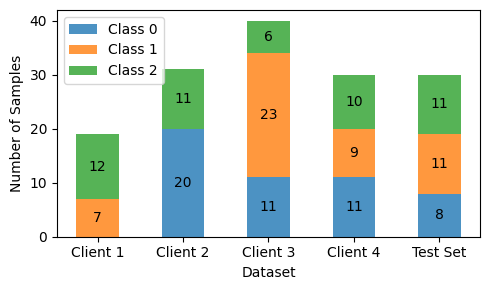

In [54]:
#Aditional plots of the data
display_dataset_split(train_data, test_data)
fig = plot_dataset_split(train_data, test_data)
save_figure(fig, "Images/iris_data_distribution.svg","svg")

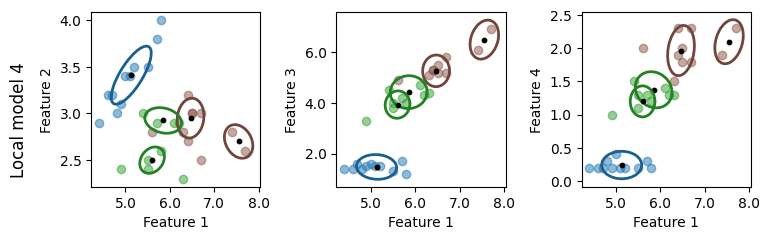

Figure saved as Images/iris_local_model.svg in svg format.
Figure saved as Images/iris_local_model.pdf in pdf format.


In [55]:
#Plot of the last local model
fig = plot_first_feature_horizontal(train_data[client_idx], model=client_model, num_sigma=2, N_max=1, title="Local model 4")  
save_figure(fig, "Images/iris_local_model.svg", "svg")
save_figure(fig, "Images/iris_local_model.pdf","pdf")

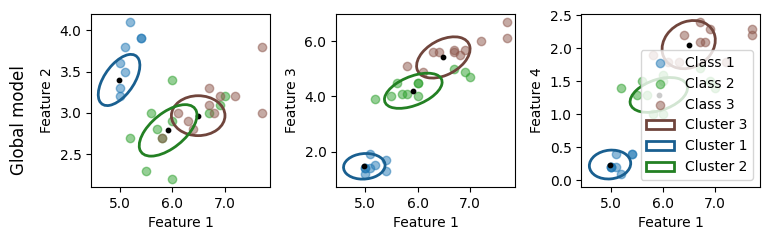

Number of clusters after merging = 3
Figure saved as Images/iris_federated_merged.svg in svg format.
Figure saved as Images/iris_federated_merged.pdf in pdf format.


In [56]:
#Plot of the last federated model
fig = plot_first_feature_horizontal(test_data, model=federated_model, num_sigma=2, N_max=0, title="Global model", legend=True)   
print(f"Number of clusters after merging = {federated_model.c}")
save_figure(fig, "Images/iris_federated_merged.svg","svg")
save_figure(fig, "Images/iris_federated_merged.pdf","pdf")